## Problem Statement

***NOTE:*** The following code is an extention to the [TS_GA.ipynb](./TSP_GA.ipynb) notebook. It incorporates a local search component into the standard genetic algorithm framework, transforming it into a ***Memetic Algorithm (MA)***. This modification is aimed at evaluating whether the inclusion of a local search can enhance the algorithm’s performance. (The [TSP_GA.ipynb](./TSP_GA.ipynb) file contains thorough explanations of the GA functions and operators. In this document, we narrow our focus to the components that are unique to the MA and we will provide detailed explanations of the MA-specific functions.)

Memetic Algorithms (MAs), also known as hybrid genetic algorithms, are an advanced form of a GAs that combines the global search perspective of genetic algorithms with local refinement techniques. The local search aspect, which is the hallmark of memetic algorithms, intensifies the search in the neighborhood of promising solutions found by the evolutionary process, aiming to enhance precision and convergence speed.

**Local Search** (Improvement Operator) is the distinguishing feature of MAs. After the traditional GA operators (selection, crossover, mutation) generate new candidates, the local search is applied to these individuals.


In [85]:
import random as rn
import numpy as np
import math
import random
import matplotlib.pyplot as plt

## Data Visualization

In [108]:
pop_size = 200
file_path = './TSP-Tests/pr1002.tsp'
x = []
y = []
n = 0

with open(file_path, 'r') as file:
    # Iterate through each line in the file
    for line in file:
        # Split the line into a list of numbers (as strings)
        parts = line.split()

        if parts[0].isdigit():
            x.append(float(parts[1]))
            y.append(float(parts[2]))

n = len(x)


Data shape:  229 229


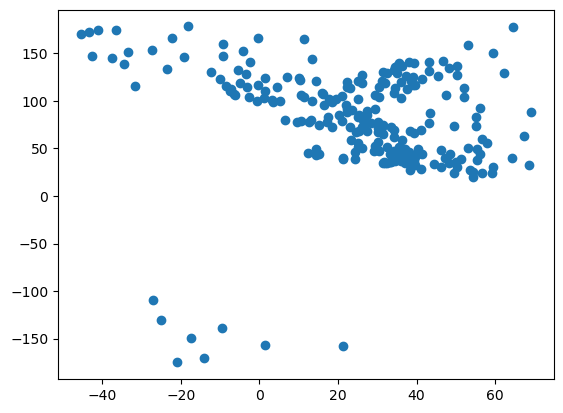

In [87]:
print('Data shape: ', len(x), len(y))
plt.scatter(x, y)
plt.show()

Data shape:  1002 1002


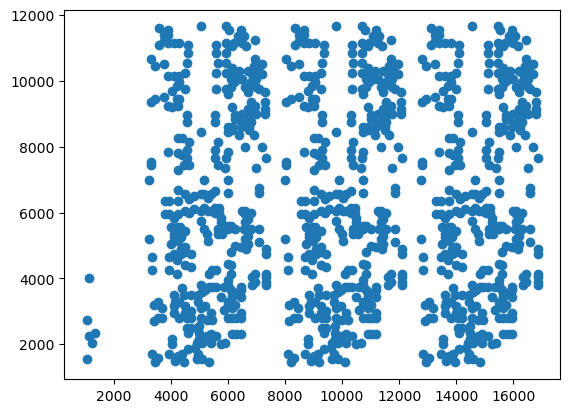

In [109]:
print('Data shape: ', len(x), len(y))
plt.scatter(x, y)
plt.show()

## Memetic Algorithm Operators

In [110]:
def eucDist(n1, n2):
    return round(math.sqrt(pow(x[n1] - x[n2], 2) + pow(y[n1] - y[n2], 2)), 3)

adj_mat = [[eucDist(i, j) for j in range(n)] for i in range(n)]

### Chromosome

All functions are priorly explained in GA implementation, the only function that actually makes difference between GA and MA is `twoOpt()` method. The 2-opt algorithm is a simple yet powerful local search strategy to improve the solution of the Traveling Salesman Problem. While it does not guarantee a global optimum, it is often very effective in practice, especially within the local search phase of a larger algorithm like the memetic algorithm. The idea is to take a route that crosses over itself and reorder it so that it does not:

- Initial Tour: Start with an initial tour, which is typically a solution produced by the genetic algorithm’s crossover and mutation processes.
- Tour Edges: Consider each pair of edges in the tour. For TSP, these edges represent connections between cities.
- Swapping Edges: At each iteration, take two non-adjacent edges in the tour and determine whether swapping the ends of these edges would result in a shorter tour.
- Making the Swap: If a shorter tour can be achieved, perform the swap, which effectively reverses the order of the cities between the two edges. This operation is known as a “2-opt move”.
- Iterate: Repeat the process, considering different pairs of edges until no more improvements can be made. The algorithm stops when reaching a local minimum, where no 2-opt move can further reduce the tour length.

Let's consider a TSP tour represented by a sequence of n nodes (cities), so we have a permutation of the nodes $ \pi = (\pi(1), \pi(2), \ldots, \pi(n))$ where $ \pi(i)$ represents the $ i^{th}$ city in the permutation. The cost (or length) associated with this tour is:

$$ C(\pi) = \sum_{i=1}^{n-1} d(\pi(i), \pi(i+1)) + d(\pi(n), \pi(1)) $$

Here, $ d(\pi(i), \pi(j)) $ represents the distance between cities $ \pi(i) $ and $ \pi(j) $. The goal of TSP is to minimize $ C(\pi) $.

In the 2-opt algorithm, two edges $ (\pi(i), \pi(i+1)) $ and $ (\pi(j), \pi(j+1)) $ are considered for removal, where $ 1 \leq i < j < n $. After cutting these edges, the paths between $ \pi(i) $ and $ \pi(j) $ and between $ \pi(i+1) $ and $ \pi(j+1) $ are reversed. This results in a new tour $ \pi' $ which is the same as $ \pi $ except between $ \pi(i) $ and $ \pi(j) $.

The change in cost after performing a 2-opt move can be computed as follows:

$$ \Delta C = [d(\pi(i), \pi(j)) + d(\pi(i+1), \pi(j+1))] - [d(\pi(i), \pi(i+1)) + d(\pi(j), \pi(j+1))] $$

If $ \Delta C $ is negative, the new configuration $ \pi' $ has lower cost, and thus the 2-opt move is accepted, yielding a shorter tour. The algorithm continues to iterate through pairs of edges untill no more improvements can be found.



In [123]:
class Chromosome:
    global x, y, n, adj_mat
    def __init__(self, chrom):
        self.chr = chrom.copy()
        self.fitness = self.fitnessFunc(self.chr)
    
    def fitnessFunc(self, chr):
        tmp = 0
        for i in range(len(chr) - 1):
            tmp += adj_mat[chr[i]][chr[i + 1]]
        tmp += adj_mat[chr[0]][chr[n - 1]]
        return tmp
    
    def mutateSwap(self, m1, m2):
        tmp = self.chr[m1]
        self.chr[m1] = self.chr[m2]
        self.chr[m2] = tmp
        self.fitness = self.fitnessFunc(self.chr)
        return
    
    def mutateScramble(self, m1, m2):
        tmp = self.chr[m1:m2]
        random.shuffle(tmp)
        self.chr[m1:m2] = tmp
        self.fitness = self.fitnessFunc(self.chr)
        return
    
    def mutateInsert(self, m1, m2):
        self.chr = self.chr[:m1] + [self.chr[m2]] + self.chr[m1: m2] + self.chr[m2 + 1:]
        self.fitness = self.fitnessFunc(self.chr)
        return
    
    def twoOpt(self):
        route = self.chr
        #print('prev fit', self.fitness)
        improved = True
        while improved:
            improved = False
            for i in range(0, n - 1):
                for j in range(i + 1, n):
                    if j - i == 1: continue  # changes nothing, skip then
                    new_route = route[:i] + route[i:j][::-1] + route[j:]
                    if self.fitnessFunc(new_route) < self.fitnessFunc(route):
                        route = new_route
                        improved = True
            self.chr = route
            self.fitness = self.fitnessFunc(route)
        #print('new fit', self.fitness)
        return 

### Initialization

In [91]:
def generatePop():
    pop = []
    c = [i for i in range(n)]
    for _ in range(pop_size):
        random.shuffle(c)
        pop.append(Chromosome(c))
    #print(f'Population of size {len(pop)} generated.')
    return pop

### Selection

In [92]:
def tournSelect(pop, p=0.1, t_round=int(pop_size/2), elit=int(pop_size/10)):
    parents = []
    pop.sort(key=lambda chr: chr.fitness)

    #elitism
    parents = pop[:elit]
    random.shuffle(pop)
    #print('parents', len(parents), parents[0].fitness)

    selected = []
    for _ in range(t_round - elit):
        selected = random.sample(pop, 3)
        selected = sorted(selected, key=lambda chr: chr.fitness)
        #print('selected', len(selected), selected[0].fitness, selected[1].fitness)
        parents.append(selected[0])
    random.shuffle(parents)
    #print(f'Selection complete! Parent pool size = {len(parents)}.')
    return parents

def truncSelect(pop):
    parents = []
    pop.sort(key=lambda chr: chr.fitness)
    parents = pop[:int(pop_size/2)]
    random.shuffle(parents)
    #print(f'Selection complete! Parent pool size = {len(parents)}.')
    return parents

### Crossover

In [93]:
def fill_rest(c, p, co):
    i = co
    while True:
        ind = i % len(p.chr)
        if c.count(p.chr[ind]) == 0:
            c.append(p.chr[ind])
        if len(c) == len(p.chr):
            break
        i += 1
    return c

def crossover2p(p_pool, cross_rate=0.9):
    offspring = []
    for _ in range(pop_size*2):
        p1, p2 = random.sample(p_pool, 2)
        if random.random() <= cross_rate:
            co1 = random.randint(0, len(p1.chr) - 1)
            co2 = random.randint(0, len(p1.chr) - 1)
            d = co2 - co1
            c1 = p2.chr[co1:co2]
            c2 = p1.chr[co1:co2]
            c1 = fill_rest(c1, p1, d)
            c2 = fill_rest(c2, p2, d)
            c1 = c1[n - co1:] + c1[:n - co2 + d]
            c1 = c2[n - co1:] + c2[:n - co2 + d]
            offspring.append(Chromosome(c1))
            offspring.append(Chromosome(c2))
        else:
            offspring.append(p1)
            offspring.append(p2)

    #print(f'Crossover complete! offsprint pool size = {len(offspring)}.')
    return offspring

def crossover1p(p_pool, cross_rate=0.9):
    offspring = []
    for _ in range(len(p_pool)):
        p1, p2 = random.sample(p_pool, 2)
        if random.random() <= cross_rate:
            p1, p2 = random.sample(p_pool, 2)
            co1 = random.randint(0, len(p1.chr) - 1)
            c1 = p1.chr[:co1]
            c2 = p2.chr[:co1]
            c1 = fill_rest(c1, p2, co1)
            c2 = fill_rest(c2, p1, co1)
            
            offspring.append(Chromosome(c1))
            offspring.append(Chromosome(c2))
        else:
            offspring.append(p1)
            offspring.append(p2)

    #print(f'Crossover complete! offspring pool size = {len(offspring)}.')
    return offspring

### Mutation

In [94]:
def mutationSwap(offs, mut_point = int(0.02*n), mut_rate = 0.1):
    for i in range(len(offs)):
        if random.random() <= mut_rate:
            for _ in range(mut_point):
                m1 = random.randint(0, len(offs[i].chr) - 1)
                m2 = random.randint(0, len(offs[i].chr) - 1)
                while m1==m2:
                    m2 = random.randint(0, len(offs[i].chr) - 1)
                offs[i].mutateSwap(m1, m2)
    
    #print(f'Mutation complete! offspring pool size = {len(offs)}.')
    return offs

def mutationScramble(offs, mut_rate):
    for i in range(len(offs)):
        if random.random() <= mut_rate:
            m1 = random.randint(0, len(offs[i].chr) - 1)
            m2 = random.randint(0, len(offs[i].chr) - 1)
            while m1==m2:
                m2 = random.randint(0, len(offs[i].chr) - 1)
            offs[i].mutateScramble(m1, m2)
    
    #print(f'Mutation complete! offspring pool size = {len(offs)}.')
    return offs

def mutationInsert(offs, mut_rate):
    for i in range(len(offs)):
        if random.random() <= mut_rate:
            m1 = random.randint(0, len(offs[i].chr) - 1)
            m2 = random.randint(0, len(offs[i].chr) - 1)
            while m1==m2:
                m2 = random.randint(0, len(offs[i].chr) - 1)
            offs[i].mutateInsert(m1, m2)
    
    #print(f'Mutation complete! offspring pool size = {len(offs)}.')
    return offs

### Replacement

In [95]:
def replacePop(p, o, elit=int(pop_size/40)):
    new_gen = []
    p.sort(key=lambda chr: chr.fitness)
    o.sort(key=lambda chr: chr.fitness)
    #elitisim applied
    new_gen = p[:elit] + o[:int(pop_size) - elit]
    random.shuffle(new_gen)
    
    #print(f'New population of size {len(new_gen)} generated')
    return new_gen

def replacePopBest(p, o):
    new_gen = []
    new_gen = p + o
    new_gen.sort(key=lambda chr: chr.fitness)
    new_gen = new_gen[:pop_size]
    random.shuffle(new_gen)
    
    #print(f'New population of size {len(new_gen)} generated')
    return new_gen

### Local Search (2-opt)

Local search in MAs is a refinement process that enhances the solution quality within a population-based evolutionary algorithm framework. The local search component is applied to chromosomes, or ***memes***, to explore their immediate neighborhood in the solution space. This is typically an iterative process, where each iteration seeks to make a small, incremental change to the solution with the intent of finding a local optimum.

The main idea behind integrating local search into GAs is to balance between the exploration of the solution space (through genetic operators like crossover and mutation) and the exploitation of the best-found solutions (through local search). This synergy enables memetic algorithms to avoid premature convergence to suboptimal regions—which can be a common issue with traditional GAs—and to fine-tune solutions to a higher degree of accuracy.

Different local search strategies can be employed within MAs, such as hill climbing, simulated annealing, or the use of domain-specific heuristics. The choice of local search method depends on the characteristics of the specific problem being solved. In our case we have applied gradient descent to only the fittest individuals (controlled by parameter `num_o`) to maintain a balance between search diversification and intensification.

Before integrating the local search method, two-opt, into our genetic algorithm, I conducted preliminary tests to ensure its effectiveness on our dataset and its ability to improve chromosome fitness. These tests were carried out in the [2optTest.ipynb](./2optTest.ipynb) notebook.

In [124]:
def localSearch(offs, num_o=1):
    offs.sort(key=lambda chr: chr.fitness)
    for i in range(num_o):
        offs[i].twoOpt()
    return offs

## Results

In [127]:
def mainGA(it_no=1000, mr=0.2, cr=0.8):
    iterations_no = it_no
    mut_rate = mr
    cross_rate = cr
    
    fitness_recorder = []
    tm = []
    last_5_fitness = []
    
    it = 0
    pop = generatePop()
    while (it <= iterations_no):
        parents = tournSelect(pop)
        offspring = crossover2p(parents, cross_rate)
        offspring = mutationScramble(offspring, mut_rate)
        offspring = localSearch(offspring)
        new_gen = replacePop(parents, offspring)

        new_gen.sort(key=lambda chr: chr.fitness)
        
        if it % int(iterations_no/5) == 0:
            print(f'Generation: {it} | Best Fitness Value: {new_gen[0].fitness}')
            fitness_recorder.append(new_gen[0].fitness)
            tm.append(it)
            last_5_fitness.append(new_gen[0].fitness)
            if len(last_5_fitness) > 5:
                last_5_fitness.pop(0)
            xx = [x[i] for i in new_gen[0].chr]
            yy = [y[i] for i in new_gen[0].chr]
            plt.scatter(x, y)
            plt.plot(xx, yy)
            plt.show()
        
        # ending criteria
        if len(last_5_fitness) == 5 and (max(last_5_fitness) - min(last_5_fitness)) < 4e-6*n:
            print("Stopping Criterion Met.")
            break

        pop = new_gen
        it += 1 
    return new_gen[0].chr, fitness_recorder, tm

### gr229

- The mutation and crossover rates did not need any adjustments so the default settings for the GA were maintained.

- Although the training was meant to run for 300 iterations, after only 100 iterations using the a superior fitness value of 1745.807 was achieved, surpassing the GA, which yielded a fitness value of 1889.703 after 5000 iterations. This demonstrates a 7% enhancement in fitness with just 0.06 times the number of iterations required by the GA on problem instance gr229.

Generation: 0 | Best Fitness Value: 1745.8069999999993


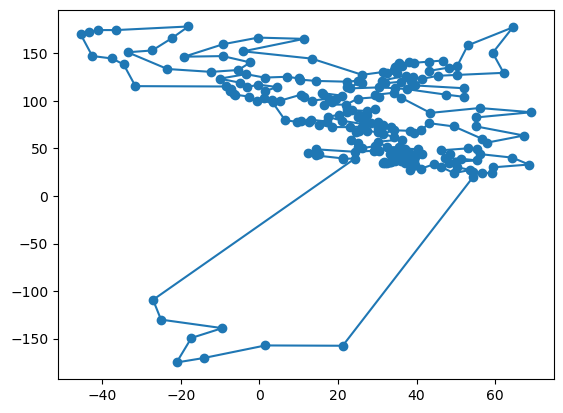

Generation: 100 | Best Fitness Value: 1745.8069999999989


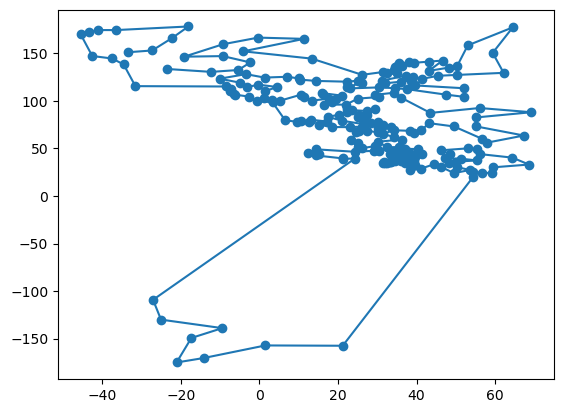

Generation: 200 | Best Fitness Value: 1745.8069999999989


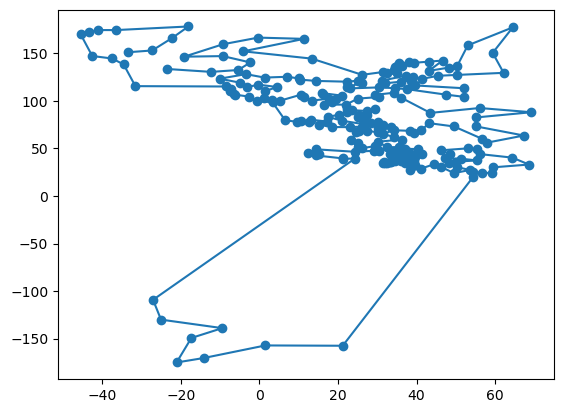

Generation: 300 | Best Fitness Value: 1745.8069999999989


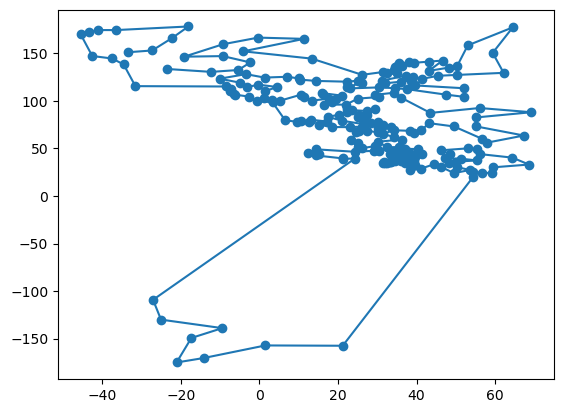

Generation: 400 | Best Fitness Value: 1745.8069999999989


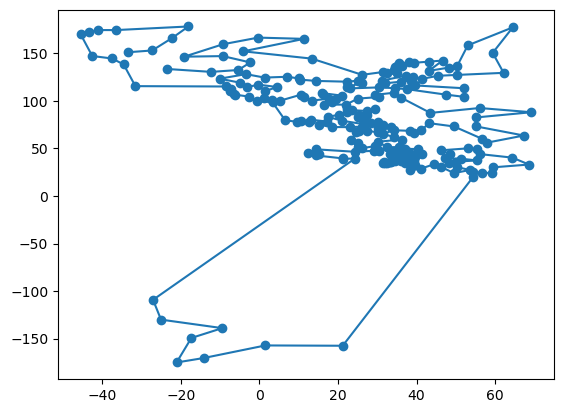

Stopping Criterion Met.


In [98]:
res_gr, recorder_gr, tm_gr = mainGA(500, 0.25, 0.9)

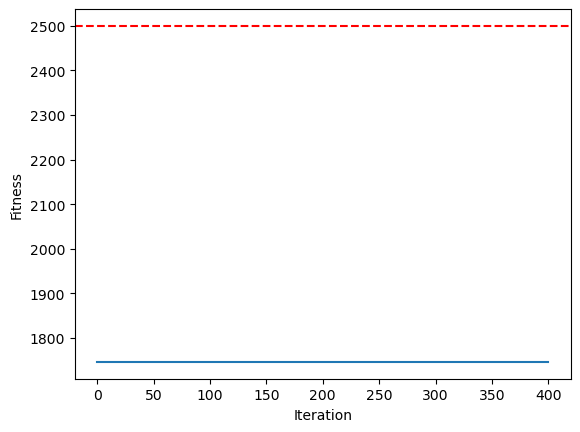

In [101]:
plt.plot(tm_gr, recorder_gr)
plt.axhline(y = 2500, color='red', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()

### pr1002

- The mutation and crossover rates did not need any adjustments so the default settings for the GA were maintained.

- After only 10 iterations using the a superior fitness value of 289605.82599999965 was achieved, surpassing the GA, which yielded a fitness value of 855497.2679999981 after 5000 iterations. This demonstrates a 66% enhancement in fitness with just 0.002 times the number of iterations required by the GA on problem instance pr1002!

Generation: 0 | Best Fitness Value: 289605.82600000006


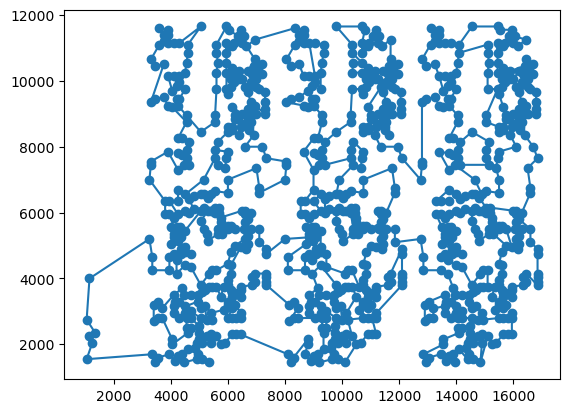

Generation: 2 | Best Fitness Value: 289605.8259999997


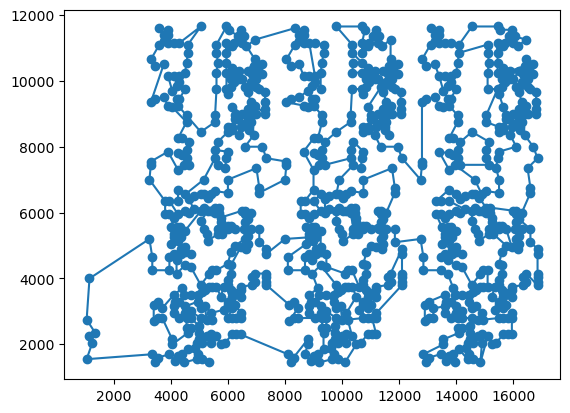

Generation: 4 | Best Fitness Value: 289605.8259999997


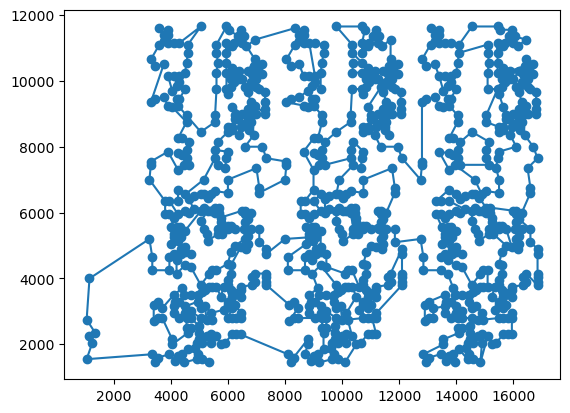

Generation: 6 | Best Fitness Value: 289605.82599999965


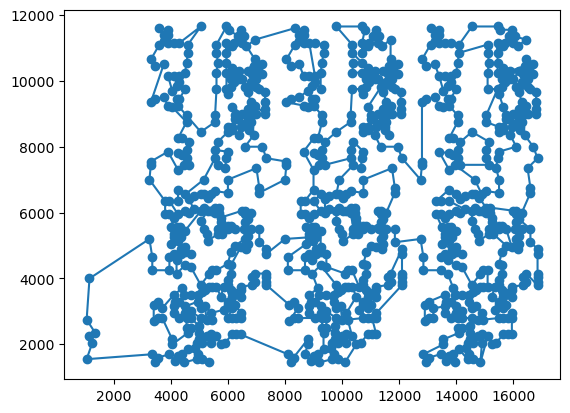

Generation: 8 | Best Fitness Value: 289605.82599999965


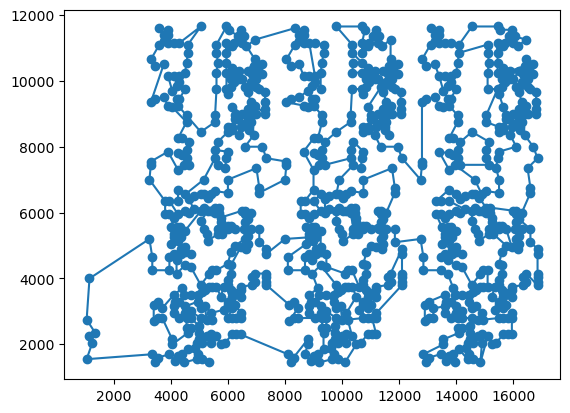

Stopping Criterion Met.


In [128]:
res_pr, recorder_pr, tm_pr = mainGA(10, 0.2, 0.9)

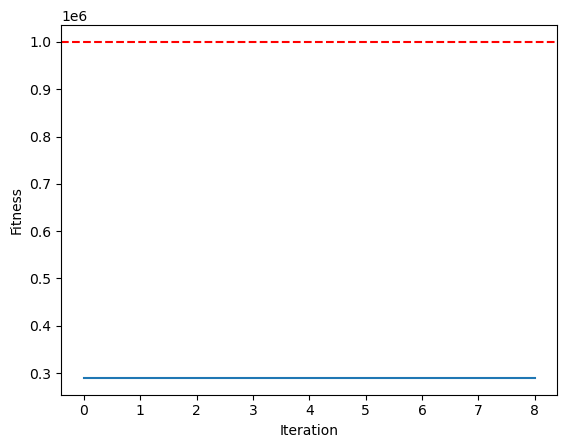

In [129]:
plt.plot(tm_pr, recorder_pr)
plt.axhline(y = 1e6, color='red', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()